In [1]:
from collections import Counter
from sklearn.datasets import make_classification
from matplotlib import pyplot
from numpy import where

from numpy import mean
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression

import tensorflow as tf
import sklearn
import numpy as np
import pandas as pd

In [2]:
print('TensorFlow v{}'.format(tf.__version__))
print(tf.config.experimental.list_physical_devices('GPU'))

hasGpu = False
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            hasGpu = True
    except RuntimeError as e:
        print(e)

print(hasGpu)

TensorFlow v2.5.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
True


# Data and Preprocessing

This dataset consisted of 3 different indicators, EMA14 EMA50 ATR14, each with the previous 5 values at the time of trade entry.  This made for a total of 15 inputs with shape (15,) and containing 3 features.  The label was whether the trade was profitable (0 no, 1 yes).  This is by design so that the deep learning model acts as a `trade filter`.  The trade entry logic is simple `if-then` logic which sends the 3 indicators' previous 5 values as input.  The model takes this input and the prediction is whether the model expects the trade to be profitable (profitable includes anything breakeven or better).  If you receive a prediction of `1`, take the trade.  If you receive a prediction of `0`, you have 2 choices.  Either 1) don't take the trade 2) flip the trade to the opposite direction (go short instead of long, or long instead of short).  A prediction of `0` indicates the model expects the trade to be a losing one.

In [3]:
features = 3
time_steps = 5
windowSize = time_steps * features
batchSize = 16
trainingFileName = './TensorFlowFib50StratES 06-21Training.bin'
#trainingFileName = './sonar.csv'
np.set_printoptions(suppress=True)

In [4]:
# build type array which matches NT8 indicators
typeArray = []
nameArray = []
#for i in range (0, windowSize):
#    typeArray.append((f'{i}', np.single))

for i in range(0, 5):
    typeArray.append((f'ema14_{i}', np.single))
    nameArray.append((f'ema14_{i}'))
    
for i in range(0, 5):
    typeArray.append((f'ema50_{i}', np.single))
    nameArray.append((f'ema50_{i}'))
    
for i in range(0, 5):
    typeArray.append((f'atr14_{i}', np.single))
    nameArray.append((f'atr14_{i}'))

# typeArray.append(('isLong', np.bool)) # direction (1 = long, 0 = short)
typeArray.append(('labels', np.int)) # is winner (label)

In [5]:
df = pd.DataFrame(np.fromfile(trainingFileName, dtype=(typeArray)))
#df = pd.read_csv(trainingFileName, header=None)
df

,ema14_0,ema14_1,ema14_2,ema14_3,ema14_4,ema50_0,ema50_1,ema50_2,ema50_3,ema50_4,atr14_0,atr14_1,atr14_2,atr14_3,atr14_4,labels
0,1277.457886,1277.430176,1277.439453,1277.380859,1277.230103,1276.714966,1276.735962,1276.765869,1276.775024,1276.754517,0.410450,0.416846,0.422786,0.446158,0.485718,0
1,1275.665649,1275.543457,1275.437744,1275.379395,1275.395386,1276.382568,1276.318604,1276.257080,1276.207764,1276.180054,0.445988,0.431989,0.401132,0.390337,0.416027,0
2,1277.730103,1277.832764,1277.988403,1278.023193,1278.020142,1277.028320,1277.086060,1277.161133,1277.203735,1277.234985,0.409185,0.415672,0.421696,0.445146,0.431207,0
3,1280.403687,1280.349854,1280.303223,1280.296143,1280.223267,1279.355225,1279.380493,1279.404785,1279.437988,1279.450195,0.414595,0.438552,0.407227,0.413854,0.420007,0
4,1278.876587,1278.826416,1278.716187,1278.654053,1278.666870,1279.300049,1279.268677,1279.218872,1279.180908,1279.164062,0.330037,0.306463,0.320287,0.315267,0.328462,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69720,4081.594238,4082.048340,4082.408691,4082.554199,4082.346924,4075.612549,4075.980713,4076.324463,4076.605957,4076.778320,2.777451,2.632633,2.587445,2.509770,2.598358,0
69721,4096.187012,4096.495605,4096.529297,4096.692383,4097.033203,4096.894043,4096.957031,4096.948730,4096.979980,4097.069336,1.773560,1.789734,1.858324,1.814873,1.828096,1
69722,4097.964355,4098.335938,4098.824219,4099.147949,4097.594727,4097.461426,4097.590332,4097.763672,4097.900391,4097.492188,2.025478,2.220087,2.329367,2.270126,3.215117,0
69723,4099.832520,4099.588379,4099.309570,4099.268555,4098.332520,4095.795898,4095.882324,4095.945801,4096.065430,4095.915771,4.407694,4.307144,4.213777,4.127079,4.493001,1


In [6]:
def create_supervised_dataset(data, isScale, isLabelEncode):
    X = []
    y = []
    
    for i in range(0, len(data)):
        X.append(data[i][:-1])
        y.append(data[i][-1])
        
    if (isScale):
        scaler = sklearn.preprocessing.StandardScaler()
        X = scaler.fit_transform(X)
        
    if (isLabelEncode):
        encoder = sklearn.preprocessing.LabelEncoder()
        encoder.fit(y)
        y = encoder.transform(y)
        y = tf.keras.utils.to_categorical(y)
    
    return np.array(X), np.array(y)

In [7]:
dataset = df.values

isLabelEncode = True
X, y = create_supervised_dataset(dataset, isScale=True, isLabelEncode=isLabelEncode)

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.33)

for i in range(0, 1):
    print(X_train[i], y_train[i])

[-1.45462513 -1.45463814 -1.45465002 -1.45466034 -1.45470409 -1.45487758
 -1.45487165 -1.45486605 -1.45486074 -1.45486579 -0.64691622 -0.67441474
 -0.70018746 -0.72339685 -0.72899668] [1. 0.]


## Look at label distribution
If the dataset is imbalanced, use `class_weights` parameter to better score the fit training

In [193]:
ones = 0
zeros = 0
total = 1

def analyze_dataset(dataset, labels):
    train_ones = []
    train_zeros = []
    for i in range(0, len(labels)):
        if (isLabelEncode == True):
            if(np.argmax(labels[i]) == 1):
                train_ones.append(1)
            if(np.argmax(labels[i]) == 0):
                train_zeros.append(0)
        elif (isLabelEncode == False):
            if(y_train[i] == 1):
                train_ones.append(1)
            if(y_train[i]== 0):
                train_zeros.append(0)

    ones = len(train_ones)
    zeros = len(train_zeros)
    total = ones + zeros
    
    ratio = np.maximum(ones, zeros) / np.minimum(ones, zeros)

    print(f'ones: {ones} zeros: {zeros}')
    print(f'if model predicts all zeros: {zeros/total:.2%}')
    print(f'if model predicts all ones: {ones/total:.2%}')

    # fit with weights
    weights = {0:1, 1:1}

    if (zeros > ones):
        weights = {0:1, 1:ratio}
        print(f'ratio 0s : 1s: {ratio}')
    else:
        weights = {0:ratio, 1:1}
        print(f'ratio 1s : 0s: {ratio}')
    pyplot.bar([0, 1], [zeros, ones])
    
    return zeros, ones, total, weights

ones: 13105 zeros: 33610
if model predicts all zeros: 71.95%
if model predicts all ones: 28.05%
ratio 0s : 1s: 2.5646699732926366


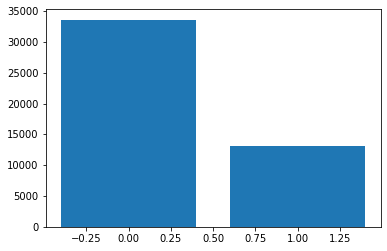

In [197]:
zeros, ones, total, weights = analyze_dataset(X_train, y_train)

ones: 6406 zeros: 16604
if model predicts all zeros: 72.16%
if model predicts all ones: 27.84%
ratio 0s : 1s: 2.5919450515142053


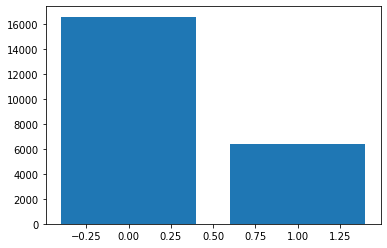

In [196]:
zeros, ones, total, weights = analyze_dataset(X_test, y_test)

In [187]:
print(f'ones: {ones} zeros: {zeros}')

ones: 6406 zeros: 16604


## Define Deep Learning Model

In [205]:
def test_model_accuracy(model):
    correct = 0
    num_predictions = 50
    for i in range(0, num_predictions):
        in_x = X_test[i].reshape(1, X_train.shape[1])
        lbl = y_test[i]
        yhat = model.predict(in_x)
        if (isLabelEncode):
            pred = np.argmax(yhat)
            actual = np.argmax(y_test[i])
            print(f'pred: [{yhat[0][0]:.3} {yhat[0][1]:.3}] actual: {y_test[i]} {"|||":10} pred: {pred} actual: {actual}')
            
            if (pred == actual):
                correct += 1
        else:
            print(f'pred: {yhat[0]:.4} actual: {y_test[i]}')
            
    print(f'correct: {correct / num_predictions:.2%}')

In [107]:
def evaluate_model(model):
    yhat = model.predict(X_test)
    # evaluate the ROC AUC of the predictions
    score = sklearn.metrics.roc_auc_score(y_test, yhat)
    print(f'ROC AUC: {score:.3%}')
    test_model_accuracy(model)

In [110]:
# define the neural network model
def simple_model(x_input, outClasses):
    # define model
    model = tf.keras.models.Sequential()
    # define first hidden layer and visible layer
    model.add(tf.keras.layers.Dense(10, input_dim=x_input.shape[1], activation='relu',  kernel_initializer='he_uniform'))
    # define output layer
    #model.add(tf.keras.layers.Dense(outClasses, activation='sigmoid'))
    model.add(tf.keras.layers.Dense(outClasses, activation='softmax'))
    # define loss and optimizer
    model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer='sgd')
    return model

In [108]:
num_out_classes = 2

### Test vanilla model

In [ ]:
model = simple_model(X_train, num_out_classes)
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, verbose=2)

In [111]:
evaluate_model(model)

Epoch 1/10
1460/1460 - 6s - loss: 0.6245 - accuracy: 0.6936 - val_loss: 0.5930 - val_accuracy: 0.7207
Epoch 2/10
1460/1460 - 5s - loss: 0.5933 - accuracy: 0.7191 - val_loss: 0.5897 - val_accuracy: 0.7215
Epoch 3/10
1460/1460 - 5s - loss: 0.5918 - accuracy: 0.7191 - val_loss: 0.5884 - val_accuracy: 0.7215
Epoch 4/10
1460/1460 - 5s - loss: 0.5913 - accuracy: 0.7195 - val_loss: 0.5882 - val_accuracy: 0.7216
Epoch 5/10
1460/1460 - 6s - loss: 0.5911 - accuracy: 0.7194 - val_loss: 0.5881 - val_accuracy: 0.7215
Epoch 6/10
1460/1460 - 5s - loss: 0.5910 - accuracy: 0.7194 - val_loss: 0.5879 - val_accuracy: 0.7215
Epoch 7/10
1460/1460 - 5s - loss: 0.5909 - accuracy: 0.7193 - val_loss: 0.5881 - val_accuracy: 0.7215
Epoch 8/10
1460/1460 - 5s - loss: 0.5908 - accuracy: 0.7195 - val_loss: 0.5878 - val_accuracy: 0.7215
Epoch 9/10
1460/1460 - 5s - loss: 0.5908 - accuracy: 0.7195 - val_loss: 0.5879 - val_accuracy: 0.7215
Epoch 10/10
1460/1460 - 5s - loss: 0.5907 - accuracy: 0.7193 - val_loss: 0.5877 - 

74% correct!!! At first glance, this looks fantastic.  However, if the training dataset is used for comparison, a model which predicts all zeros must do better than 71.95%.  The numbers are slightly different for the test dataset but the idea is the same.  Due to the stochastic nature of deep learning, this approximately 2% advantage should be met with significant skepticism.  Given the fact that the dataset is imbalanced, the `class_weight` parameter should be utilized at a minimum.  SMOTE or other sampling techniques would likely be a more robust way to evaluate this model.

In classification problems, accuracy on tells part of the story (often a less important part).  ROC AUC and F1 score are often a much better indicator of the ability of the model.  This super simple model only achieves a ROC AUC of 55% which is nothing stellar and is not likely to have reliable prediction skill.

The final indication that this model is essentially garbage is the predictions are always 0.  There could be several reasons for this:
 - Massive overfitting (most likely in this case)
 - Too aggressive of a learning rate
 - Too complex of a model (model just memorizes the dataset)
 - Imbalanced dataset
 
This model's predictions vary only a slight amount and always are heavily weighted to predict zero.  The fact that the prediction probabilities do change means that the model is sound, but is just overall terrible.  This is to be expected with a single Dense layer with only 10 neurons.

### Test properly class weighted model

In [15]:
# fit with weights
weights = {0:1, 1:1}

if (zeros > ones):
    #weights = {0:ratio, 1:1}
    weights = {0:1, 1:ratio}
else:
    #weights = {0:1, 1:ratio}
    weights = {0:ratio, 1:1}

model = define_model(X_train, num_out_classes)
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, verbose=2, class_weight=weights)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/10
1460/1460 - 6s - loss: 1.0014 - accuracy: 0.5640 - val_loss: 0.6877 - val_accuracy: 0.5658
Epoch 2/10
1460/1460 - 6s - loss: 0.9923 - accuracy: 0.5568 - val_loss: 0.6925 - val_accuracy: 0.5341
Epoch 3/10
1460/1460 - 6s - loss: 0.9922 - accuracy: 0.5464 - val_loss: 0.6834 - val_accuracy: 0.5651
Epoch 4/10
1460/1460 - 6s - loss: 0.9921 - accuracy: 0.5525 - val_loss: 0.6977 - val_accuracy: 0.5229
Epoch 5/10
1460/1460 - 6s - loss: 0.9920 - accuracy: 0.5440 - val_loss: 0.6819 - val_accuracy: 0.5682
Epoch 6/10
1460/1460 - 6s - loss: 0.9920 - accuracy: 0.5520 - val_loss: 0.6906 - val_accuracy: 0.5407
Epoch 7/10
1460/1460 - 6s - loss: 0.9919 - accuracy: 0.5496 - val_loss: 0.7003 - val_accuracy: 0.5161
Epoch 8/10
1460/1460 - 6s - loss: 0.9918 - accuracy: 0.5455 - val_loss: 0.6870 - val_accuracy: 0.5507
Epoch 9/10
1460/1460 - 6s - loss: 0.9918 - acc

In [18]:
evaluate_model(model):

ROC AUC: 55.630%
pred: [0.4229445  0.57705545] actual: [1. 0.] |||        pred: 1 actual: 0
pred: [0.62145513 0.3785449 ] actual: [1. 0.] |||        pred: 0 actual: 0
pred: [0.41913956 0.5808605 ] actual: [0. 1.] |||        pred: 1 actual: 1
pred: [0.35279363 0.6472064 ] actual: [1. 0.] |||        pred: 1 actual: 0
pred: [0.51803356 0.48196644] actual: [1. 0.] |||        pred: 0 actual: 0
pred: [0.5645756  0.43542436] actual: [1. 0.] |||        pred: 0 actual: 0
pred: [0.60645044 0.3935496 ] actual: [1. 0.] |||        pred: 0 actual: 0
pred: [0.4228555 0.5771445] actual: [0. 1.] |||        pred: 1 actual: 1
pred: [0.40475908 0.59524095] actual: [1. 0.] |||        pred: 1 actual: 0
pred: [0.5370234 0.4629766] actual: [1. 0.] |||        pred: 0 actual: 0
pred: [0.4626595  0.53734046] actual: [0. 1.] |||        pred: 1 actual: 1
pred: [0.36453125 0.6354687 ] actual: [0. 1.] |||        pred: 1 actual: 1
pred: [0.4810305 0.5189695] actual: [1. 0.] |||        pred: 1 actual: 0
pred: [0.52447

This model with adjusted class weights gives a much more accurate representation of this model's true abilities.  When digging into the predictions, they do vary between predicting each of the 2 classes (0 and 1 - loser/winner).  however, the model's confidence is not great.  If I were to use a model in actual trading, I would want the model to be much, much more certain of its predicction 90% or better.  That would correspond to [0.9 0.1] for a zero (predict a loser, so don't trade) or [0.1 0.9] for a one (predicting a winner, take the trade).

The ROC AUC is only 55.6% which is still terrible.  I would want something well over 80% before I even considered forward testing it on a demo account.  The accuracy of 50% is much more representative of this model's true ability.  It has no skill due to any one or more of the following:

 - The features do not possess any predictive information (most likely the case).
 - The model is not of sufficient complexity to extract predictive relationships in the data (also very likely).
 - Class weighting was not sufficient to overcome the dataset imbalance.

# Try more advanced models

In [19]:
def simple_deeper(x_input, outClasses):
    # define model
    model = tf.keras.models.Sequential()
    # define first hidden layer and visible layer
    model.add(tf.keras.layers.Dense(50, input_dim=x_input.shape[1], activation='relu',  kernel_initializer='he_uniform'))
    model.add(tf.keras.layers.Dense(10, activation='relu',  kernel_initializer='he_uniform'))
    # define output layer
    #model.add(tf.keras.layers.Dense(outClasses, activation='sigmoid'))
    model.add(tf.keras.layers.Dense(outClasses, activation='softmax'))
    # define loss and optimizer
    model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer='sgd')
    return model

In [120]:
def CNN(x_input, outClasses):
    # let's use the functional api to build this one
    visible = tf.keras.layers.Input(shape=(x_input.shape[1]))
    
    #CNN requires 3D input in the shape [samples, time_steps, features]
    print(f'time_steps: {time_steps} featuers: {features}')
    reshape = tf.keras.layers.Reshape(target_shape=(time_steps,features))(visible)
    
    cnn = tf.keras.layers.Conv1D(32, kernel_size=2, strides=1, activation=tf.keras.activations.relu, padding='same')(reshape)
    cnn = tf.keras.layers.Conv1D(32, kernel_size=2, strides=1, activation=tf.keras.activations.relu, padding='same')(reshape)
    pool = tf.keras.layers.MaxPooling1D()(cnn)
    flat = tf.keras.layers.Flatten()(pool)
    
    output = tf.keras.layers.Dense(outClasses, activation=tf.keras.activations.sigmoid)(flat)
    
    model = tf.keras.models.Model(inputs=visible, outputs=output)
    model.compile(loss=tf.keras.losses.binary_crossentropy, optimizer='sgd', metrics=['accuracy'])
    
    return model

In [121]:
X_train.shape

(46715, 15)

In [122]:
model = CNN(X_train, num_out_classes)

time_steps: 5 featuers: 3


In [123]:
model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_27 (InputLayer)        [(None, 15)]              0         
_________________________________________________________________
reshape_21 (Reshape)         (None, 5, 3)              0         
_________________________________________________________________
conv1d_34 (Conv1D)           (None, 5, 32)             224       
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 2, 32)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 64)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 2)                 130       
Total params: 354
Trainable params: 354
Non-trainable params: 0
_____________________________________________________________

In [126]:
# test a prediction to verify model design
x_input = X_test[0]
x_input = x_input.reshape(1,X_test.shape[1])
yhat = model.predict(x_input)
print(f'raw prediction: {yhat[0]} predicted label: {np.argmax(yhat[0])}')

raw prediction: [0.54786   0.7192231] predicted label: 1


In [127]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, verbose=2)

Epoch 1/10
1460/1460 - 5s - loss: 0.6076 - accuracy: 0.7123 - val_loss: 0.5921 - val_accuracy: 0.7215
Epoch 2/10
1460/1460 - 4s - loss: 0.5926 - accuracy: 0.7193 - val_loss: 0.5892 - val_accuracy: 0.7215
Epoch 3/10
1460/1460 - 4s - loss: 0.5912 - accuracy: 0.7194 - val_loss: 0.5886 - val_accuracy: 0.7214
Epoch 4/10
1460/1460 - 4s - loss: 0.5907 - accuracy: 0.7193 - val_loss: 0.5888 - val_accuracy: 0.7216
Epoch 5/10
1460/1460 - 4s - loss: 0.5906 - accuracy: 0.7194 - val_loss: 0.5880 - val_accuracy: 0.7215
Epoch 6/10
1460/1460 - 4s - loss: 0.5905 - accuracy: 0.7195 - val_loss: 0.5881 - val_accuracy: 0.7216
Epoch 7/10
1460/1460 - 4s - loss: 0.5905 - accuracy: 0.7194 - val_loss: 0.5880 - val_accuracy: 0.7215
Epoch 8/10
1460/1460 - 4s - loss: 0.5904 - accuracy: 0.7194 - val_loss: 0.5879 - val_accuracy: 0.7214
Epoch 9/10
1460/1460 - 4s - loss: 0.5905 - accuracy: 0.7194 - val_loss: 0.5879 - val_accuracy: 0.7215
Epoch 10/10
1460/1460 - 4s - loss: 0.5904 - accuracy: 0.7195 - val_loss: 0.5880 - 

In [129]:
evaluate_model(model)

ROC AUC: 55.441%
pred: [0.6974353 0.2989538] actual: [1. 0.] |||        pred: 0 actual: 0
pred: [0.7678357  0.23545521] actual: [1. 0.] |||        pred: 0 actual: 0
pred: [0.714232  0.2913712] actual: [0. 1.] |||        pred: 0 actual: 1
pred: [0.64331245 0.35564148] actual: [1. 0.] |||        pred: 0 actual: 0
pred: [0.735261   0.25863504] actual: [1. 0.] |||        pred: 0 actual: 0
pred: [0.7526814  0.24416482] actual: [1. 0.] |||        pred: 0 actual: 0
pred: [0.7721209  0.22969149] actual: [1. 0.] |||        pred: 0 actual: 0
pred: [0.6984429  0.30058646] actual: [0. 1.] |||        pred: 0 actual: 1
pred: [0.67184204 0.32218963] actual: [1. 0.] |||        pred: 0 actual: 0
pred: [0.7399283  0.25608483] actual: [1. 0.] |||        pred: 0 actual: 0
pred: [0.73074716 0.27386573] actual: [0. 1.] |||        pred: 0 actual: 1
pred: [0.6723269  0.33441693] actual: [0. 1.] |||        pred: 0 actual: 1
pred: [0.7224862  0.27406755] actual: [1. 0.] |||        pred: 0 actual: 0
pred: [0.747

Even with a significantly more advanced model architecture, the non class weighted model performs virtually identical to the extremely simple single Dense layer model.

In [135]:
model = CNN(X_train, num_out_classes)
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, verbose=2, class_weight=weights)

time_steps: 5 featuers: 3
Epoch 1/50
1460/1460 - 4s - loss: 0.9992 - accuracy: 0.5708 - val_loss: 0.6964 - val_accuracy: 0.5571
Epoch 2/50
1460/1460 - 4s - loss: 0.9934 - accuracy: 0.5837 - val_loss: 0.6860 - val_accuracy: 0.6011
Epoch 3/50
1460/1460 - 4s - loss: 0.9928 - accuracy: 0.5771 - val_loss: 0.6851 - val_accuracy: 0.5926
Epoch 4/50
1460/1460 - 4s - loss: 0.9925 - accuracy: 0.5745 - val_loss: 0.6934 - val_accuracy: 0.5525
Epoch 5/50
1460/1460 - 4s - loss: 0.9923 - accuracy: 0.5646 - val_loss: 0.6820 - val_accuracy: 0.5929
Epoch 6/50
1460/1460 - 4s - loss: 0.9922 - accuracy: 0.5663 - val_loss: 0.6891 - val_accuracy: 0.5621
Epoch 7/50
1460/1460 - 4s - loss: 0.9921 - accuracy: 0.5640 - val_loss: 0.7006 - val_accuracy: 0.5155
Epoch 8/50
1460/1460 - 4s - loss: 0.9921 - accuracy: 0.5534 - val_loss: 0.6803 - val_accuracy: 0.5947
Epoch 9/50
1460/1460 - 4s - loss: 0.9921 - accuracy: 0.5628 - val_loss: 0.6817 - val_accuracy: 0.5895
Epoch 10/50
1460/1460 - 4s - loss: 0.9920 - accuracy: 0.

In [136]:
evaluate_model(model)

ROC AUC: 55.387%
pred: [0.47852793 0.5147453 ] actual: [1. 0.] |||        pred: 1 actual: 0
pred: [0.5710444  0.43485552] actual: [1. 0.] |||        pred: 0 actual: 0
pred: [0.47914904 0.5174108 ] actual: [0. 1.] |||        pred: 1 actual: 1
pred: [0.40179121 0.5961109 ] actual: [1. 0.] |||        pred: 1 actual: 0
pred: [0.5164035  0.47852772] actual: [1. 0.] |||        pred: 0 actual: 0
pred: [0.540234  0.4625015] actual: [1. 0.] |||        pred: 0 actual: 0
pred: [0.5703057 0.4350108] actual: [1. 0.] |||        pred: 0 actual: 0
pred: [0.47672233 0.51606303] actual: [0. 1.] |||        pred: 1 actual: 1
pred: [0.4503415 0.5531159] actual: [1. 0.] |||        pred: 1 actual: 0
pred: [0.51860744 0.47851732] actual: [1. 0.] |||        pred: 0 actual: 0
pred: [0.49212158 0.50521904] actual: [0. 1.] |||        pred: 1 actual: 1
pred: [0.4330365 0.5738932] actual: [0. 1.] |||        pred: 1 actual: 1
pred: [0.50752896 0.48682916] actual: [1. 0.] |||        pred: 0 actual: 0
pred: [0.5209014

The accuracy of this CNN-based model is fairly noticeable improvement over the very simple model with a 8% improvement.  However, the ROC AUC is virtually identical which means this model is essentially no better with the quality of its predictions.  If we carefully analyze the `take trade (1)` versus `don't take trade (0)`, there are quite a significant false negatives.  The high ratio of false negatives combined with the low confidence of the predicted label could mean a few things:

 - This model need more training.  Even with 50 epochs, the model simply became overfitted with no improvement in skill.
 - The features do not have strong predictive information.  This is looking much more of a certainty now.
 
Let's try other architectures to see if there is any salvaging these indicator based inputs
 - Encoder decoder
 - Recurrent Stacked LSTM

## Enccoder Decoder

In [145]:
def encoder_decoder(x_input, outClasses):
    # let's use the functional api to build this one
    visible = tf.keras.layers.Input(shape=(x_input.shape[1]))    
    reshape = tf.keras.layers.Reshape(target_shape=(time_steps,features))(visible)
    
    enc = tf.compat.v1.keras.layers.LSTM(20, activation='relu')(reshape)
        
    bottleneck = tf.keras.layers.RepeatVector(outClasses)(enc)
    dec = tf.compat.v1.keras.layers.LSTM(20, activation='relu', return_sequences=True)(bottleneck)
    
    dec  = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(time_steps, activation='relu'))(dec)
    dec = tf.keras.layers.Flatten()(dec)
    output = tf.keras.layers.Dense(outClasses, activation='softmax')(dec)    
    
    model = tf.keras.models.Model(inputs=visible, outputs=output)
    model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6), metrics=['accuracy'])
    
    return model

In [146]:
model = encoder_decoder(X_train, num_out_classes)

In [147]:
model.summary()

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_34 (InputLayer)        [(None, 15)]              0         
_________________________________________________________________
reshape_27 (Reshape)         (None, 5, 3)              0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 20)                1920      
_________________________________________________________________
repeat_vector_3 (RepeatVecto (None, 2, 20)             0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 2, 20)             3280      
_________________________________________________________________
time_distributed_1 (TimeDist (None, 2, 5)              105       
_________________________________________________________________
flatten_5 (Flatten)          (None, 10)                0   

In [149]:
# test a prediction to verify model design
x_input = X_test[0]
x_input = x_input.reshape(1,X_test.shape[1])
yhat = model.predict(x_input)
print(f'raw prediction: {yhat[0]} predicted label: {np.argmax(yhat[0])}')

raw prediction: [0.49987254 0.5001275 ] predicted label: 1


In [153]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, verbose=2, class_weight=weights)

Epoch 1/10
1460/1460 - 77s - loss: 0.9971 - accuracy: 0.4336 - val_loss: 0.6937 - val_accuracy: 0.4432
Epoch 2/10
1460/1460 - 75s - loss: 0.9971 - accuracy: 0.4529 - val_loss: 0.6937 - val_accuracy: 0.4615
Epoch 3/10
1460/1460 - 75s - loss: 0.9971 - accuracy: 0.4710 - val_loss: 0.6937 - val_accuracy: 0.4768
Epoch 4/10
1460/1460 - 75s - loss: 0.9970 - accuracy: 0.4849 - val_loss: 0.6936 - val_accuracy: 0.4912
Epoch 5/10
1460/1460 - 76s - loss: 0.9970 - accuracy: 0.4941 - val_loss: 0.6936 - val_accuracy: 0.5024
Epoch 6/10
1460/1460 - 77s - loss: 0.9970 - accuracy: 0.5073 - val_loss: 0.6936 - val_accuracy: 0.5117
Epoch 7/10
1460/1460 - 76s - loss: 0.9970 - accuracy: 0.5153 - val_loss: 0.6936 - val_accuracy: 0.5196
Epoch 8/10
1460/1460 - 77s - loss: 0.9970 - accuracy: 0.5226 - val_loss: 0.6936 - val_accuracy: 0.5245
Epoch 9/10
1460/1460 - 76s - loss: 0.9970 - accuracy: 0.5284 - val_loss: 0.6936 - val_accuracy: 0.5297
Epoch 10/10
1460/1460 - 77s - loss: 0.9969 - accuracy: 0.5334 - val_loss:

In [154]:
evaluate_model(model)

ROC AUC: 54.801%
pred: [0.49445245 0.5055475 ] actual: [1. 0.] |||        pred: 1 actual: 0
pred: [0.5022087  0.49779126] actual: [1. 0.] |||        pred: 0 actual: 0
pred: [0.49965802 0.500342  ] actual: [0. 1.] |||        pred: 1 actual: 1
pred: [0.4906386 0.5093614] actual: [1. 0.] |||        pred: 1 actual: 0
pred: [0.49976245 0.5002375 ] actual: [1. 0.] |||        pred: 1 actual: 0
pred: [0.49927184 0.5007282 ] actual: [1. 0.] |||        pred: 1 actual: 0
pred: [0.50061977 0.4993802 ] actual: [1. 0.] |||        pred: 0 actual: 0
pred: [0.49412128 0.50587875] actual: [0. 1.] |||        pred: 1 actual: 1
pred: [0.49528664 0.5047133 ] actual: [1. 0.] |||        pred: 1 actual: 0
pred: [0.49858567 0.5014143 ] actual: [1. 0.] |||        pred: 1 actual: 0
pred: [0.50013626 0.49986374] actual: [0. 1.] |||        pred: 0 actual: 1
pred: [0.48749173 0.5125083 ] actual: [0. 1.] |||        pred: 1 actual: 1
pred: [0.5010623 0.4989377] actual: [1. 0.] |||        pred: 0 actual: 0
pred: [0.501

This model architecture took significantly more system resources to train.  After 10 epochs of traininig, the validation accuracy was still climbing but the loss had remained constsant.  This accuracy was still below 50% which leads me to believe that the model was not actually learning but moving towards predicting only on class.  When analyzing the `evaluate_model`, the confidence of the predictions is very close to a coin flip despite the model predicting both classes.  Again, the ROC AUC was 54% which is a terrible score for this model.

After a further 10 epochs, the model reached a validation accuracy over 50%, 52.97%.  However, when evaluating the model and the test dataset, which it had not seen, the accuracy remained underwhelming at 56%.  Still, the ROC AUC remained well below an acceptable level with a mere 54.8%.

In [167]:
def stacked_lstm(x_input, outClasses):
    visible = tf.keras.layers.Input(shape=(x_input.shape[1]))    
    reshape = tf.keras.layers.Reshape(target_shape=(time_steps,features))(visible)    
    
    rnn = tf.compat.v1.keras.layers.LSTM(4, activation='relu', kernel_constraint=tf.keras.constraints.max_norm(3), return_sequences=True)(reshape)
    rnn = tf.compat.v1.keras.layers.LSTM(4, activation='relu', kernel_constraint=tf.keras.constraints.max_norm(2))(rnn)
    #rnn = Flatten()(rnn)
    
    output = tf.keras.layers.Dense(outClasses, activation='softmax')(rnn)
    
    model = tf.keras.models.Model(inputs=visible, outputs=output)
    model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), metrics=['accuracy'])
    
    return model

In [168]:
model = stacked_lstm(X_train, num_out_classes)

In [169]:
model.summary()

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_39 (InputLayer)        [(None, 15)]              0         
_________________________________________________________________
reshape_32 (Reshape)         (None, 5, 3)              0         
_________________________________________________________________
lstm_16 (LSTM)               (None, 5, 4)              128       
_________________________________________________________________
lstm_17 (LSTM)               (None, 4)                 144       
_________________________________________________________________
dense_23 (Dense)             (None, 2)                 10        
Total params: 282
Trainable params: 282
Non-trainable params: 0
_________________________________________________________________


In [200]:
# test a prediction to verify model design
x_input = X_test[0]
x_input = x_input.reshape(1,X_test.shape[1])
yhat = model.predict(x_input)
print(f'raw prediction: [{yhat[0][0]:.4} {yhat[0][1]:.4}] predicted label: {np.argmax(yhat[0])}')

raw prediction: [0.4937 0.5063] predicted label: 1


In [171]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, verbose=2, class_weight=weights)

Epoch 1/10
1460/1460 - 116s - loss: 0.9970 - accuracy: 0.3227 - val_loss: 0.6948 - val_accuracy: 0.3367
Epoch 2/10
1460/1460 - 115s - loss: 0.9970 - accuracy: 0.3527 - val_loss: 0.6947 - val_accuracy: 0.3503
Epoch 3/10
1460/1460 - 117s - loss: 0.9970 - accuracy: 0.3761 - val_loss: 0.6947 - val_accuracy: 0.3656
Epoch 4/10
1460/1460 - 113s - loss: 0.9969 - accuracy: 0.3836 - val_loss: 0.6946 - val_accuracy: 0.4003
Epoch 5/10
1460/1460 - 114s - loss: 0.9969 - accuracy: 0.4260 - val_loss: 0.6946 - val_accuracy: 0.4484
Epoch 6/10
1460/1460 - 114s - loss: 0.9969 - accuracy: 0.4542 - val_loss: 0.6946 - val_accuracy: 0.4780
Epoch 7/10
1460/1460 - 114s - loss: 0.9968 - accuracy: 0.4742 - val_loss: 0.6946 - val_accuracy: 0.4912
Epoch 8/10
1460/1460 - 111s - loss: 0.9968 - accuracy: 0.4949 - val_loss: 0.6946 - val_accuracy: 0.4981
Epoch 9/10
1460/1460 - 116s - loss: 0.9968 - accuracy: 0.5005 - val_loss: 0.6946 - val_accuracy: 0.5039
Epoch 10/10
1460/1460 - 116s - loss: 0.9968 - accuracy: 0.5026 -

In [206]:
evaluate_model(model)

ROC AUC: 54.080%
pred: [0.494 0.506] actual: [1. 0.] |||        pred: 1 actual: 0
pred: [0.501 0.499] actual: [1. 0.] |||        pred: 0 actual: 0
pred: [0.498 0.502] actual: [0. 1.] |||        pred: 1 actual: 1
pred: [0.474 0.526] actual: [1. 0.] |||        pred: 1 actual: 0
pred: [0.5 0.5] actual: [1. 0.] |||        pred: 0 actual: 0
pred: [0.497 0.503] actual: [1. 0.] |||        pred: 1 actual: 0
pred: [0.498 0.502] actual: [1. 0.] |||        pred: 1 actual: 0
pred: [0.492 0.508] actual: [0. 1.] |||        pred: 1 actual: 1
pred: [0.497 0.503] actual: [1. 0.] |||        pred: 1 actual: 0
pred: [0.498 0.502] actual: [1. 0.] |||        pred: 1 actual: 0
pred: [0.498 0.502] actual: [0. 1.] |||        pred: 1 actual: 1
pred: [0.478 0.522] actual: [0. 1.] |||        pred: 1 actual: 1
pred: [0.502 0.498] actual: [1. 0.] |||        pred: 0 actual: 0
pred: [0.501 0.499] actual: [0. 1.] |||        pred: 0 actual: 1
pred: [0.497 0.503] actual: [1. 0.] |||        pred: 1 actual: 0
pred: [0.499

# Conclusion

More of the same despite yet another model architecture.  ROC AUC of 54% and test dataset accuracy of 50%.  This leads me to believe that the dataset does not contain predictive features.

To test this theory, I used another known dataset, the sonar dataset available here: https://archive.ics.uci.edu/ml/datasets/Connectionist+Bench+(Sonar,+Mines+vs.+Rocks), actually it's up one level so that link is the dataset description.  All of the models performed significantly better in every case.  Most achieved ROC AUC of well over 70%-80% which is a significant difference.

This was a very interesting experiment in which I learned a ton.  I consider these models a basic framework on which to test additional filter style deep learning models for trading.  Going forward, I intend to investigate:

 - Additional indicators.
 - Larger window sizes.
 - Multi-headed models which can handle different types of data (indicator head, market opening type head, market state [consolidation expansion] head).
 - Additional model architectures such as Attention, Inception, ResNet, etc.
 - Level 2 order book data. 